<a href="https://colab.research.google.com/github/MercyMoparthy/project-nlp-challenge/blob/main/NLPModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 3: Baseline Model with Stemming + Naive Bayes

Set up a basic pipeline using manual text preprocessing and Logistic Regression.

## 🔧 Steps:
1. Import Librairies and load data (Assign columns name)

2. Preprocessing:

    - Remove punctuation and digits

    - Tokenize

    - Remove stopwords

    - Stemming (using NLTK’s PorterStemmer)

    - Join tokens back into a string

3. Vectorization:

    - TF-IDF Vectorization

4. Model:

    - Naive Bayes + Data Augmentation + Grid Search

5. Evaluation:

    - Accuracy, confusion matrix, classification report

6. Prediction for Testing Data

##  ✅ Purpose:
Establish a working pipeline and baseline score (~70-80% accuracy is expected here).

## 1. Import Librairies and load data

In [87]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
import matplotlib.pyplot as plt

In [49]:
data = pd.read_csv("data/training_data_lowercase.csv", sep="\t", header=None, names=["label", "title"])
data.reset_index(drop=True, inplace=True)  # optional

data.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [50]:
# validating duplicate values
print("Duplicate titles:", data['title'].duplicated().sum())

Duplicate titles: 1946


In [89]:
data = data.drop_duplicates(subset='title')
print("Duplicate titles:", data['title'].duplicated().sum())

Duplicate titles: 0


## 2. Preprocessing:
* StopWords
* Tokenization
* Stemmer and Lemmatizer
* Removing Special Characters and Digits

In [90]:
# class distribution
print("Class distribution:\n", data['label'].value_counts(normalize=True))

Class distribution:
 label
1    0.502422
0    0.497578
Name: proportion, dtype: float64


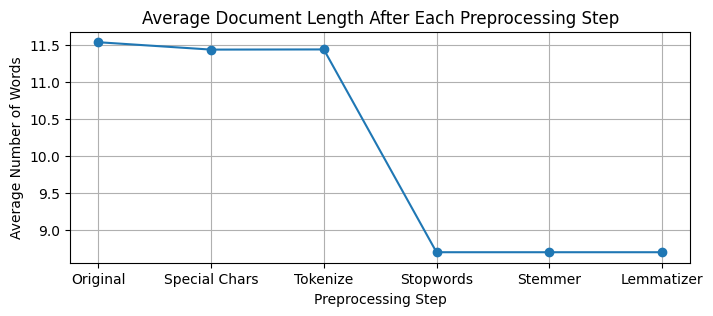

In [91]:
# Step 1: For plotting (intermediate results)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
special_removed = data['title'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
tokenized = special_removed.apply(word_tokenize)
no_stopwords = tokenized.apply(lambda tokens: [w for w in tokens if w.lower() not in stop_words])
stemmed = no_stopwords.apply(lambda tokens: [stemmer.stem(w) for w in tokens])
lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])

steps = [
    "Original",
    "Special Chars",
    "Tokenize",
    "Stopwords",
    "Stemmer",
    "Lemmatizer"
]
avg_lengths = [
    data['title'].apply(lambda x: len(x.split())).mean(),
    special_removed.apply(lambda x: len(x.split())).mean(),
    tokenized.apply(len).mean(),
    no_stopwords.apply(len).mean(),
    stemmed.apply(len).mean(),
    lemmatized.apply(len).mean()
]

plt.figure(figsize=(8,3))
plt.plot(steps, avg_lengths, marker='o')
plt.title("Average Document Length After Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Average Number of Words")
plt.grid(True)
plt.show()

In [92]:
# Download stopwords
nltk.download('stopwords', quiet=True)
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}  # Keep negation words
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-strings
        return ""
    
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove Special Characters
    text = re.sub(r'\b\w\b', '', text) # remove single characters
    tokens = word_tokenize(text.lower()) # Tokenize
    tokens = [w for w in tokens if w.lower() not in stop_words] # remove stop words
    tokens = [char for char in tokens if char not in string.punctuation and not char.isdigit()] # remove punctuations and digits
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # lemmatizing
    # Join tokens
    return " ".join(tokens)
# Apply preprocessing
data['clean_title'] = data['title'].apply(preprocess_text)
# Check results
print("Sample processed titles:\n", data[['title', 'clean_title']].head())

Sample processed titles:
                                                title  \
0  donald trump sends out embarrassing new year‚s...   
1  drunk bragging trump staffer started russian c...   
2  sheriff david clarke becomes an internet joke ...   
3  trump is so obsessed he even has obama‚s name ...   
4  pope francis just called out donald trump duri...   

                                         clean_title  
0  donald trump sends embarrassing new year eve m...  
1  drunk bragging trump staffer started russian c...  
2  sheriff david clarke becomes internet joke thr...  
3  trump obsessed even obamas name coded website ...  
4  pope francis called donald trump christmas speech  


In [93]:
# Word Frequency
word_freq = Counter(tokens).most_common(20)
print("Top 20 words:", word_freq)

Top 20 words: [('to', 12604), ('trump', 10350), ('in', 6369), ('for', 5637), ('of', 5576), ('video', 5505), ('on', 5215), ('the', 4864), ('us', 4103), ('a', 3078), ('with', 2806), ('says', 2614), ('and', 2574), ('is', 2313), ('trumps', 1900), ('obama', 1884), ('after', 1834), ('house', 1801), ('at', 1630), ('as', 1512)]


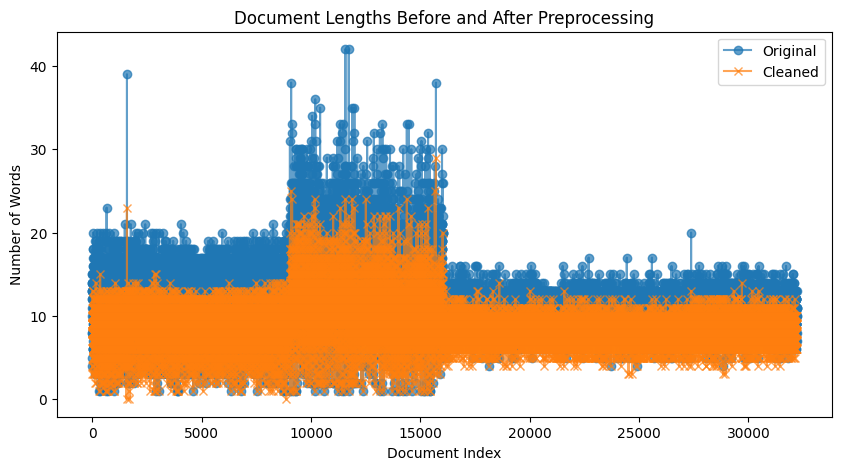

In [94]:
# Calculate document lengths before and after preprocessing
orig_lengths = data['title'].apply(lambda x: len(x.split()))
clean_lengths = data['clean_title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.plot(orig_lengths.values, label='Original', marker='o', alpha=0.7)
plt.plot(clean_lengths.values, label='Cleaned', marker='x', alpha=0.7)
plt.title('Document Lengths Before and After Preprocessing')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

Class Distribution

C:\Users\Mercy\AppData\Local\Temp\ipykernel_31468\3775043527.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette=bar_colors)


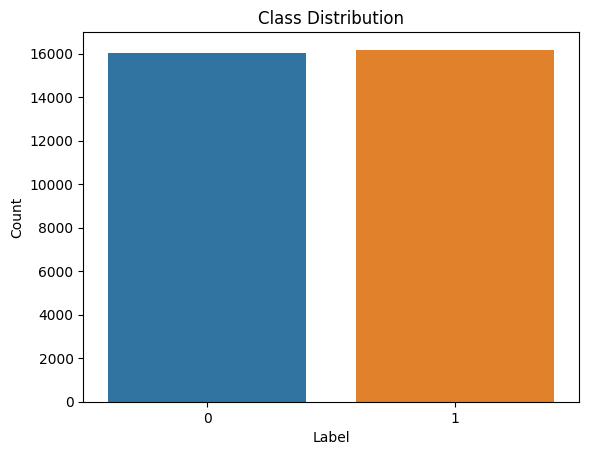

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
bar_colors = ['#1f77b4', '#ff7f0e']
sns.countplot(x='label', data=data, palette=bar_colors)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## 3. Train Split and Vectorization

Create a TF-IDF Representation

In [96]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data["clean_title"], data["label"], test_size=0.2, random_state=42)
print("Training set:", len(X_train), "titles, Test set:", len(X_test), "titles")

Training set: 25764 titles, Test set: 6442 titles


In [107]:
nltk.download('wordnet', quiet=True)
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)

# Function to get synonyms
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym != word and synonym.isalpha():  # Single-word, alphabetic synonyms
                synonyms.append(synonym)
    return synonyms[:2]  # Limit to 2 synonyms

# Augmentation function: Insert a synonym
def augment_title(title):
    if not isinstance(title, str) or len(title.split()) < 3:  # Skip short titles
        return None
    words = word_tokenize(title)
    if len(words) < 3:
        return None
    import random
    # Pick a random word to find a synonym for
    idx = random.randint(0, len(words) - 1)
    if words[idx] not in stop_words:  # Only augment non-stopwords
        synonyms = get_synonyms(words[idx])
        if synonyms:
            # Insert a random synonym after the word
            words.insert(idx + 1, random.choice(synonyms))
            new_title = " ".join(words)
            return new_title if new_title != title else None
    return None

# Augment training data
augmented_titles = []
augmented_labels = []
for title, label in zip(X_train, y_train):
    augmented_titles.append(title)  # Keep original
    augmented_labels.append(label)
    # Add up to 2 augmented versions (80% chance each)
    import random
    for _ in range(2):
        if random.random() < 0.8:
            aug_title = augment_title(title)
            if aug_title:
                augmented_titles.append(aug_title)
                augmented_labels.append(label)

# Update training data
X_train = pd.Series(augmented_titles)
y_train = pd.Series(augmented_labels)

# Check results
print("Original training titles:", len(X_train) // 2)  # Approx. original count
print("Augmented training titles:", len(augmented_titles))
print("Sample augmented titles:\n", X_train.head(5))

Original training titles: 43975
Augmented training titles: 87950
Sample augmented titles:
 0        israel question iranian blogger giving asylum
1    israel question iranian Irani blogger giving a...
2    u company tout climate policy fund climate ske...
3    u company tout tipster climate policy fund cli...
4    u company tout climate policy insurance fund c...
dtype: object


In [113]:
tfidf_vectorizer = TfidfVectorizer(
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    max_features=10000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# x_tfidf is a sparse matrix of TF-IDF features
print(X_train_tfidf.shape) 
print("TF-IDF Representation:\n", X_train_tfidf.toarray())
print(X_test_tfidf.shape)

(87950, 10000)
TF-IDF Representation:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(6442, 10000)


## 4. Naive Bayes Regression Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB
import time
start_time = time.time()
model = ComplementNB() # Train Naive Bayes with GridSearchCV
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]} 
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best training accuracy:", round(grid_search.best_score_, 4))
training_time = (time.time() - start_time) / 60



Best parameters: {'alpha': 0.5}
Best training accuracy: 0.9241


## 5. Evaluation

In [ ]:
train_pred = grid_search.predict(X_train_tfidf) 
test_pred = grid_search.predict(X_test_tfidf)
print("Predicted Training Values:", train_pred[:5]) 
print("Predicted Testing Values:", test_pred[:5])
print("Training Accuracy:", accuracy_score(y_train, train_pred))
print("Testing Accuracy:", accuracy_score(y_test, test_pred))

Predicted Training Values: [1 1 1 1 1]
Predicted Testing Values: [1 1 1 0 0]
Training Accuracy: 0.9456281978396817
Testing Accuracy: 0.9304563800062092


In [119]:
# Predict and evaluate
y_pred = grid_search.best_estimator_.predict(X_test_tfidf)
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9304563800062092
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3233
           1       0.94      0.92      0.93      3209

    accuracy                           0.93      6442
   macro avg       0.93      0.93      0.93      6442
weighted avg       0.93      0.93      0.93      6442



HeatMap

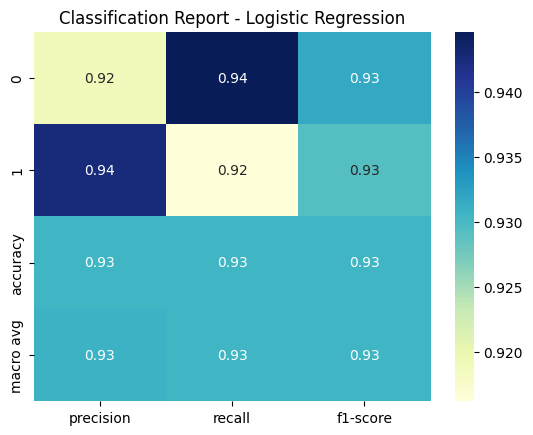

In [117]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report - Logistic Regression')
plt.show()

## 6. Confusion Matrix

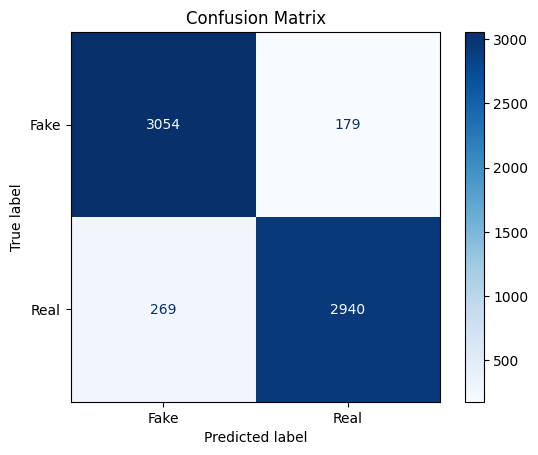

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true_labels = data['label']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Save Model with Metrics

In [ ]:
# Save results using the model_eval module
save_model_results(
    model_name="NLPModel1_LoR",
    display_name="Logistic Regression",
    accuracy=test_accuracy, 
    training_time_minutes=training_time,  
    model_architecture="Logistic Regression with TF-IDF Vectorization",
    preprocessing_type="NLP Basic PreProcessing",
    train_accuracy=train_accuracy, 
)
print("Model results saved successfully!")
print(f"Model:Logistic Regression + TF-IDF Vectorizer")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training Time: {training_time:.2f} minutes")